## 5.3 Задачи детекции и сегментации

В данном задании вам предстоит помочь The Nature Conservancy в борьбе с рыбаками-браконьерами. 

Необходимо по снимкам с камеры на рыболовецком судне классифицировать улов. 

За основу решения предлагается взять модель детектора: https://github.com/a4tunado/lectures/blob/master/007/007-detection.ipynb

Решение необходимо прислать в виде ссылки на ipython-ноутбук с указанием значения метрики на Leaderboard.

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

In [4]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf

print(tf.__version__)

2.18.0


Загружаем разметку

In [5]:
import zipfile

In [7]:
import os
import json
from glob import glob

TRAIN_PREFIX = 'C:/Users/ksurashanti/netology/5.3/train'

def load_annotations(): #загружаем разметку данных и парсим её для нейросети
    boxes = dict()
    for path in glob('D:/netology/007/data/fish/boxes/*.json'): #файл загружаем
        label = os.path.basename(path).split('_', 1)[0]
        with open(path) as src:
            for annotation in json.load(src):
                basename = os.path.basename(annotation['filename'])
                annotation['filename'] = os.path.join(
                    TRAIN_PREFIX, label.upper(), basename)
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
                if os.path.isfile(annotation['filename']):
                    boxes.setdefault(label, []).append(annotation)
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None): #рисуем разметку (какие рыбы где находятся?)
    
    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=4)
        return img
    
    scale_x, scale_y = 1., 1.
    
    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)
        
    img = _draw(img, annotation.get('annotations', []), scale_x, scale_y)
    
    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

In [8]:
TRAIN_PREFIX

'C:/Users/ksurashanti/netology/5.3/train'

Визуализируем разметку

In [10]:
boxes = load_annotations()  # загружаем разметку детекций

In [11]:
pd.DataFrame(
    [(k, len(v)) for k, v in boxes.items()],
    columns=['class', 'count'])

,class,count
0,alb,1719
1,bet,200
2,dol,117
3,lag,67
4,shark,176
5,yft,734


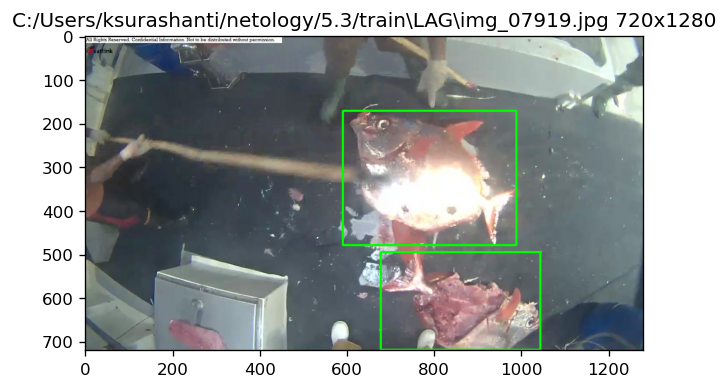

In [12]:
from matplotlib import pyplot as plt
#пока НЕ учим классифицировать рыб, учим находить всех рыб и обводить их в рамочку


annotation = boxes['lag'][0]
img = draw_boxes(annotation)

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(img)
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

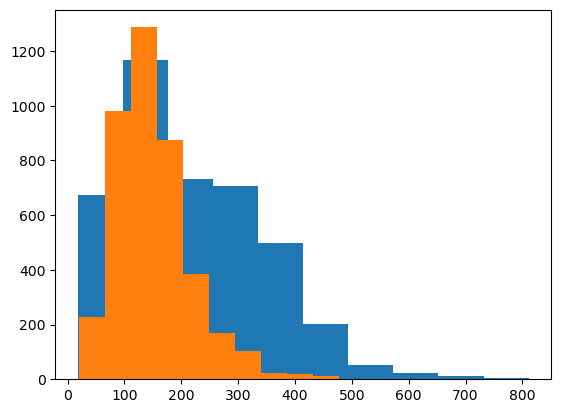

In [13]:
annotations = sum([box['annotations'] #распределение размеров рамок. тут гистрограмма для высоты и гистограмма для ширины
                   for box in sum(boxes.values(), [])], [])

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths)
plt.hist(heights);


Экстрактор признаков

In [199]:
from tensorflow.keras.applications import vgg16

IMG_HEIGHT = 1200
IMG_WIDTH = 750

features = vgg16.VGG16(weights='imagenet', #базовая нс
                       include_top=False,
                       input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# дообучаем последние 5 слоев
for layer in features.layers[:-5]:
    layer.trainable = False
    
feature_tensor = features.layers[-1].output
print(feature_tensor.shape)

(None, 37, 23, 512)


Сетка якорей

In [17]:
FEATURE_SHAPE = (feature_tensor.shape[1], #сетка якорей отвечает за хранение тех или иных рамочек
                 feature_tensor.shape[2])

#надо указать шаг этой сетки, для этого делим высоту и ширину на размер выхода нс vgg
GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150. #за какую область отвечает та или иная ячейка 150х150 px вокруг себя
ANCHOR_HEIGHT = 150. 

# сетка якорей, размер определяется соотношением 
# размера входного изображения и размером тензора признаков


ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

In [18]:
def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):
    
    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale
    
    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale
    
    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2
    
    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))
    
    intersection = dx * dy if (dx > 0 and dy > 0) else 0. #рассчитываем метрику пересечение двух рамок, потом объединение
    
    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection
    
    return intersection / union

def encode_anchors(annotation, img_shape, iou_thr=0.5): #для кодирования разметки в формат, удобной для нс
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1], 5), dtype=np.float32)
    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]
    for rect in annotation['annotations']:
        scores = []
        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))
        
        scores = sorted(scores, reverse=True)
        if scores[0][0] < iou_thr:
            scores = [scores[0]]  # default anchor
        else:
            scores = [e for e in scores if e[0] > iou_thr]

        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            encoded[row, col] = [1., dx, dy, dw, dh]
            
    return encoded

def _sigmoid(x): #функция активации последнего слоя нейронной сети (использщуется в задачах бинарной классификации)
    #в рамках многоклассовой классификации мы проводим бинарную (является ли рыба внутри рамки рыбой?)
    return 1. / (1. + np.exp(-x))

def decode_prediction(prediction, conf_thr=0.1): #парсим результат работы нс, чтобы можно было нарисовать
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):
            logit, dx, dy, dw, dh = prediction[row, col]
            conf = _sigmoid(logit)
            if conf > conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf})
    return rectangles

def non_max_suppression(rectangles, max_output_size, iou_threshold=0.5): #для удаления дубликатов рамочек
    if not rectangles:
        return rectangles
    
    boxes = [[r['y'],
              r['x'],
              r['y'] + r['height'],
              r['x'] + r['width']] for r in rectangles]
    scores = [r['conf'] for r in rectangles]
    indices = tf.image.non_max_suppression(np.array(boxes),
                                           np.array(scores),
                                           max_output_size,
                                           iou_threshold)
    
    return [rectangles[i] for i in indices]

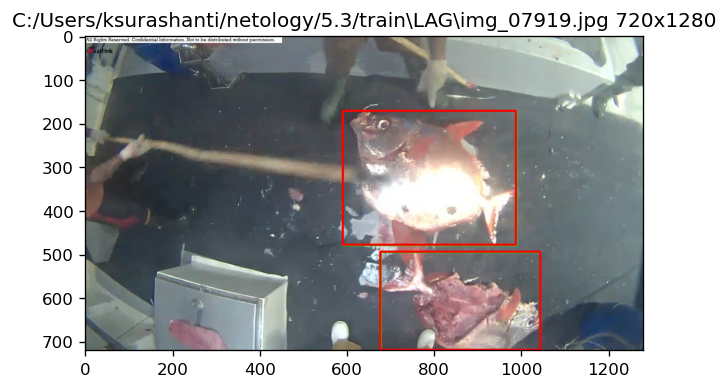

In [19]:
annotation = boxes['lag'][0]

encoded = encode_anchors(annotation,
                         img_shape=(IMG_HEIGHT, IMG_WIDTH),
                         iou_thr=0.5)

decoded = decode_prediction(encoded, conf_thr=0.7)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(annotation, decoded))
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

Функция потерь

In [21]:
K = tf.keras.backend

def confidence_loss(y_true, y_pred): #для ф-ии потерь. оценивает, насколько хорошо производится классификация
    conf_loss = K.binary_crossentropy(y_true[..., 0], #классификация бинарная, определяем есть ли рыба в рамке
                                      y_pred[..., 0],
                                      from_logits=True)
    return conf_loss

def smooth_l1(y_true, y_pred): #контроль насколько хорошо предсказываются рамки. гибрид мае и все. при малых мае, при больших мсе
    abs_loss = K.abs(y_true[..., 1:] - y_pred[..., 1:])
    square_loss = 0.5 * K.square(y_true[..., 1:] - y_pred[..., 1:])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)

def total_loss(y_true, y_pred, neg_pos_ratio=3): #суммирование двух прошлых функций, синтезирует положительные и отрицательные примеры#
    batch_size = K.shape(y_true)[0]
    
    # TODO: добавьте функцию потерь для классификации детекции
    
    y_true = K.reshape(y_true, (batch_size, -1, 5))
    y_pred = K.reshape(y_pred, (batch_size, -1, 5))

    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)
    
    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)
    
    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * y_true[..., 0], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 0], axis=-1)
    
    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., 0], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])
    
    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 0]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)
    
    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)
    
    return total_conf_loss + 0.5 * loc_loss

Загрузка данных

In [23]:
from random import shuffle

def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, vgg16.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, batch_size=32):
    boxes = sum(boxes.values(), [])
    while True:
        shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j]['filename'])
                # TODO: добавьте one-hot encoding в разметку для классов
                y.append(encode_anchors(boxes[j], img_shape))
                X.append(img)
            yield np.array(X), np.array(y)

Добавляем выходной слой:

In [130]:
output = tf.keras.layers.BatchNormalization()(feature_tensor)

# TODO: добавьте выходы для классификации детекции
output = tf.keras.layers.Conv2D(5,
                                kernel_size=(1, 1), 
                                activation='linear',
                                kernel_regularizer='l2')(output)

model = tf.keras.models.Model(inputs=features.inputs, outputs=output)
model.summary()

C:\Users\ksurashanti\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 750, 1200, 3)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 750, 1200, 64)  │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 750, 1200, 64)  │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 375, 600, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 375, 600, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 375, 600, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 187, 300, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 187, 300, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 187, 300, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 187, 300, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 93, 150, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 93, 150, 512)   │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 93, 150, 512)   │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 93, 150, 512)   │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 46, 75, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 46, 75, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 46, 75, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 46, 75, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 23, 37, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 23, 37, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 23, 37, 5)      │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,719,301 (56.15 MB)

 Trainable params: 7,083,013 (27.02 MB)

 Non-trainable params: 7,636,288 (29.13 MB)

Обучение

In [27]:
!pip install -U keras

In [28]:
lr=3e-3
def lr_exp_decay(epoch, lr):
    k = 0.5
    return lr * np.exp(-k*epoch)

batch_size = 5
steps_per_epoch = sum(map(len, boxes.values()), 0) / batch_size

gen = data_generator(boxes, batch_size=batch_size)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'fishdetector.keras',
    monitor='loss',
    verbose=47,  
    save_best_only=True, 
    save_weights_only=False,
    mode='auto',
    save_freq=10)

adam = tf.keras.optimizers.Adam(learning_rate=3e-4, decay=1e-6)
model.compile(optimizer=adam, 
              loss=total_loss,
              metrics=[confidence_loss])

C:\Users\ksurashanti\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [29]:
steps_per_epoch #как-то это перебор, ограничимся 20

602.6

In [30]:
batch_size = 5

gen = data_generator(boxes, batch_size=batch_size)
steps_per_epoch = 20

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'fishdetector.keras',
    monitor='loss',
    verbose=1,  
    save_best_only=True, 
    save_weights_only=False,
    mode='auto',
    save_freq=10)

model.fit(gen, 
          steps_per_epoch=steps_per_epoch,
          epochs=50,
          callbacks=[checkpoint])

Epoch 1/50


C:\Users\ksurashanti\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


 9/20 ━━━━━━━━━━━━━━━━━━━━ 2:06 11s/step - confidence_loss: 0.9046 - loss: 6.0276
Epoch 1: loss improved from inf to 4.97240, saving model to fishdetector.keras
19/20 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - confidence_loss: 0.8839 - loss: 5.2334
Epoch 1: loss improved from 4.97240 to 4.12357, saving model to fishdetector.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 241s 12s/step - confidence_loss: 0.8795 - loss: 5.1277
Epoch 2/50
 9/20 ━━━━━━━━━━━━━━━━━━━━ 2:06 11s/step - confidence_loss: 0.7314 - loss: 2.5057
Epoch 2: loss improved from 4.12357 to 2.31141, saving model to fishdetector.keras
19/20 ━━━━━━━━━━━━━━━━━━━━ 11s 12s/step - confidence_loss: 0.7117 - loss: 2.3403
Epoch 2: loss improved from 2.31141 to 2.03630, saving model to fishdetector.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 236s 12s/step - confidence_loss: 0.7086 - loss: 2.3114
Epoch 3/50
 9/20 ━━━━━━━━━━━━━━━━━━━━ 2:06 12s/step - confidence_loss: 0.6013 - loss: 1.5654
Epoch 3: loss improved from 2.03630 to 1.47450, saving model to fishdetector.k

In [31]:
decoded

[{'x': 790.000001723702,
  'y': 324.9999985098839,
  'width': 397.99999594688416,
  'height': 307.99999237060547,
  'conf': 0.7310585896677003},
 {'x': 860.999999497388,
  'y': 606.9999996410764,
  'width': 366.00000858306885,
  'height': 224.00000095367432,
  'conf': 0.7310585896677003}]

1/1 ━━━━━━━━━━━━━━━━━━━━ 497s 497s/step


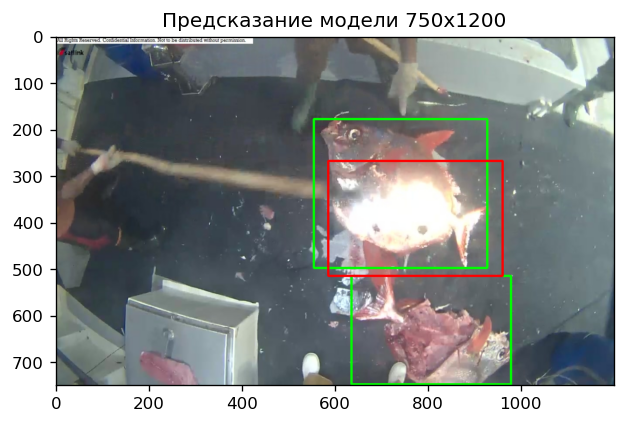

In [34]:
annotation = boxes['lag'][0]

_, sample_img = load_img(annotation['filename'])
pred = model.predict(np.array([sample_img,]))

decoded = decode_prediction(pred[0], conf_thr=0.2) #Декодирует прогноз модели ImageNet. По умолчанию была в VGG
                                                   #первый параметр - массив нумпай, кодирующий пакет прогнозов
decoded = non_max_suppression(decoded,      #Жадно выбирает подмножество ограничивающих рамок в 
                                                #порядке убывания оценок.
                              max_output_size=5,
                              iou_threshold=0.1)

plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(annotation, decoded, (IMG_WIDTH, IMG_HEIGHT))
plt.imshow(img)
plt.title('Предсказание модели {}x{}'.format(*img.shape));

1/1 ━━━━━━━━━━━━━━━━━━━━ 460s 460s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 462s 462s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 459s 459s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 460s 460s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 461s 461s/step


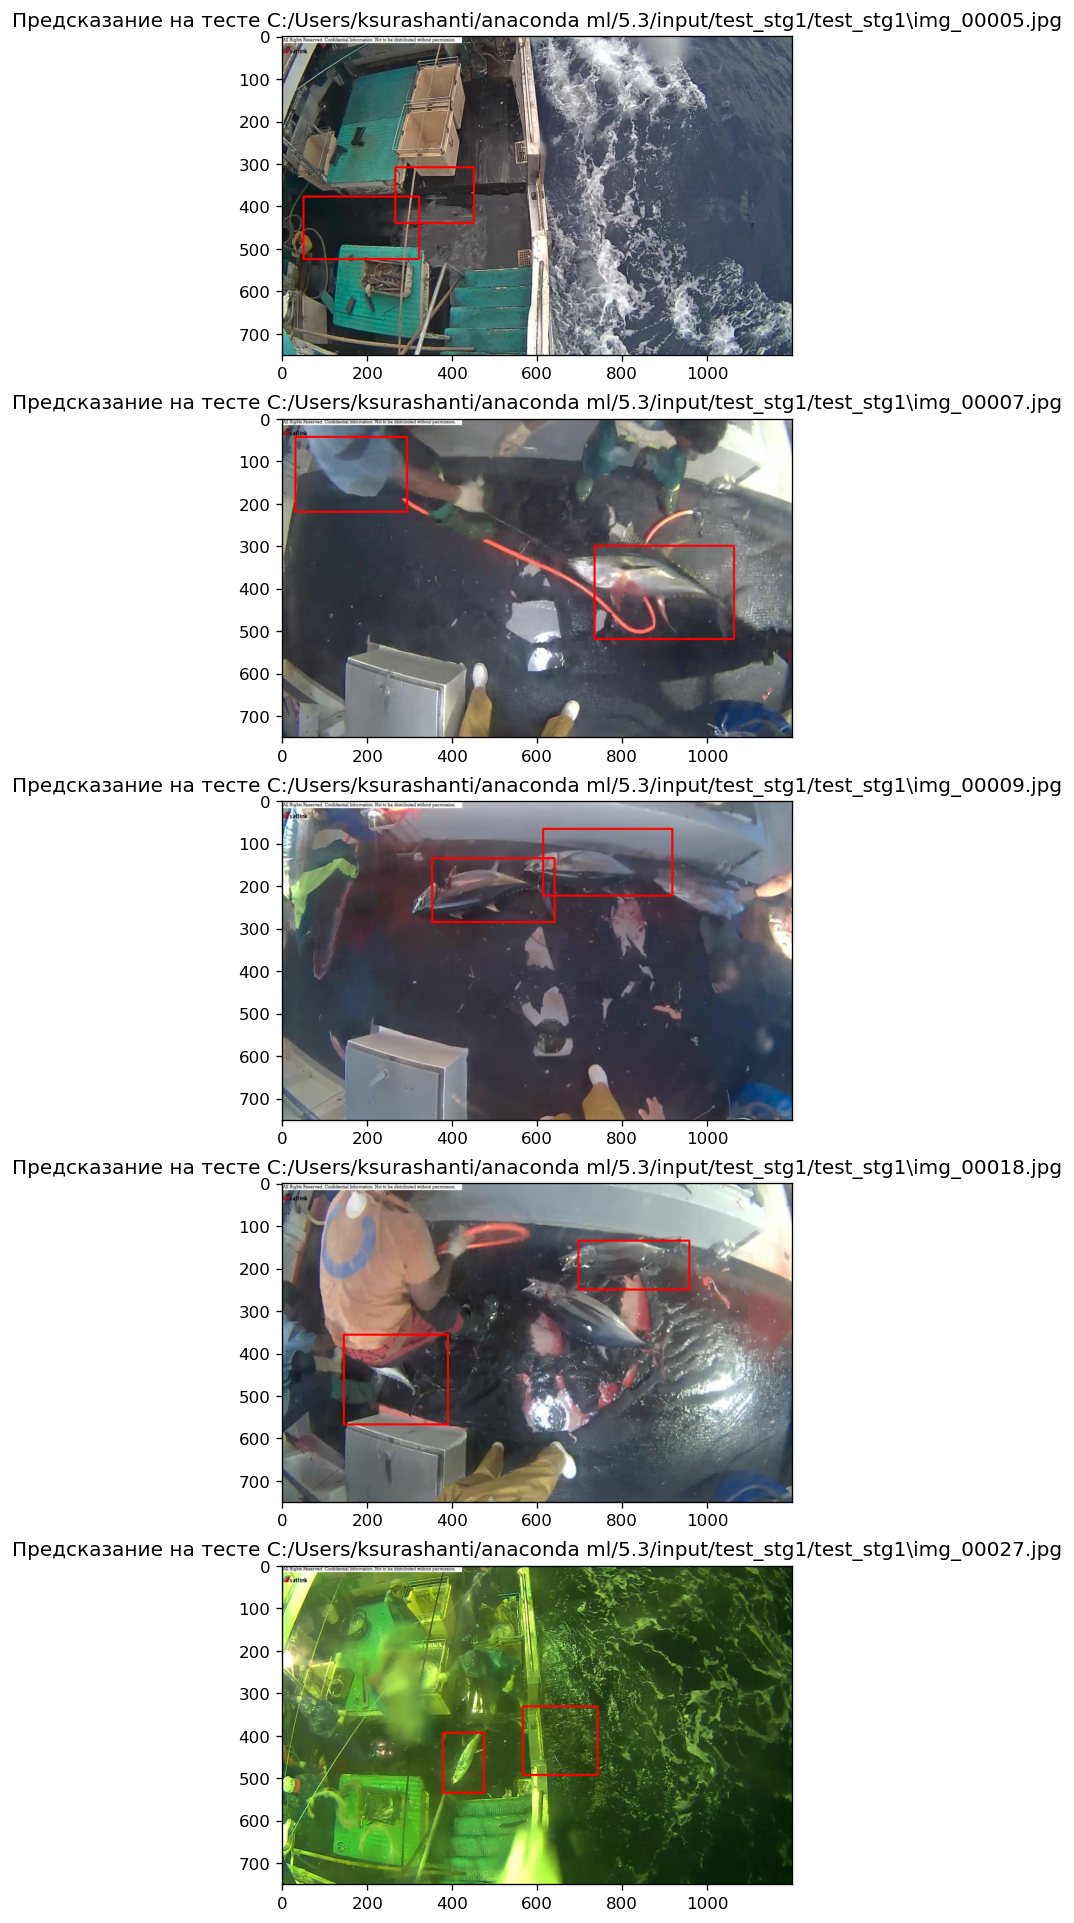

In [38]:
test_images = glob('C:/Users/ksurashanti/anaconda ml/5.3/input/test_stg1/test_stg1/*.jpg')[:5]


plt.figure(figsize=(6, 4 * len(test_images)), dpi=120)

for i, filename in enumerate(test_images):
    _, sample_img = load_img(filename)
    pred = model.predict(np.array([sample_img,]))

    decoded = decode_prediction(pred[0], conf_thr=0.0) 
    decoded = non_max_suppression(decoded,
                                  max_output_size=2,
                                  iou_threshold=0.1)
    
    plt.subplot(len(test_images), 1, i + 1)
    img = draw_boxes({'filename': filename}, decoded, (IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(img)
    plt.title('Предсказание на тесте {}'.format(filename));

In [ ]:
# TODO: предскажите класс рыбы для фотографии из тестовой выборки
#
# Подготовьте файл с предсказаниями вероятностей для каждой фотографии:
# image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
# img_00001.jpg,1,0,0,0,0,...,0
# img_00002.jpg,0.3,0.1,0.6,0,...,0